In [104]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# load data from a csv file
df = pd.read_csv('/content/sample_data/train.csv')
df = df.drop('Id', axis=1)
df_test = pd.read_csv('/content/sample_data/test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# !pip install lightgbm
# !pip install optuna
# !pip install shap
import shap
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [105]:
selected_columns = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1',
       'GarageCars', 'OverallCond', 'LotArea', 'YearRemodAdd', '1stFlrSF',
       'Fireplaces', 'GarageArea','OpenPorchSF', '2ndFlrSF',
       'TotRmsAbvGrd', 'FullBath', 'HalfBath', 'MSSubClass', 'BedroomAbvGr', 'KitchenAbvGr', 'SalePrice']
df = df[selected_columns]
df_test = df_test[selected_columns[:-1]]

In [117]:
X, y = df.drop("SalePrice", axis=1), df["SalePrice"]

In [91]:
# Define objective function for Optuna
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        "n_estimators": trial.suggest_int('n_estimators', 50, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int("max_depth", 5, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'subsample': trial.suggest_float('subsample', 0.7, 0.8),
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 5),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 3),
        'min_child_weight': trial.suggest_float('min_child_weight', 2, 50),
    }

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    rmse_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_test = y[train_idx], y[val_idx]

        model = lgb.LGBMRegressor(**params)

        # Fit the model on training data
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose = False)

        y_pred_val = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))
        rmse_scores.append(rmse)

    # Calculate mean RMSE score across cross-validation folds
    mean_rmse = np.mean(rmse_scores)

    return mean_rmse


In [92]:
# Create Optuna study
study = optuna.create_study(direction='minimize')

# Optimize hyperparameters
study.optimize(objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params

# Train the final model with the best hyperparameters
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X, y)

[I 2023-04-17 03:09:58,951] A new study created in memory with name: no-name-66b78dca-99fb-441d-89f0-8be456444005
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0613318583976126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0613318583976126
[LightGBM] [Warning] lambda_l2 is set=2.898081857451396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.898081857451396


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0613318583976126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0613318583976126
[LightGBM] [Warning] lambda_l2 is set=2.898081857451396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.898081857451396


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0613318583976126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0613318583976126
[LightGBM] [Warning] lambda_l2 is set=2.898081857451396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.898081857451396


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0613318583976126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0613318583976126
[LightGBM] [Warning] lambda_l2 is set=2.898081857451396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.898081857451396


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0613318583976126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0613318583976126
[LightGBM] [Warning] lambda_l2 is set=2.898081857451396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.898081857451396


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0613318583976126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0613318583976126
[LightGBM] [Warning] lambda_l2 is set=2.898081857451396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.898081857451396


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0613318583976126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0613318583976126
[LightGBM] [Warning] lambda_l2 is set=2.898081857451396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.898081857451396


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0613318583976126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0613318583976126
[LightGBM] [Warning] lambda_l2 is set=2.898081857451396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.898081857451396


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0613318583976126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0613318583976126
[LightGBM] [Warning] lambda_l2 is set=2.898081857451396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.898081857451396


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0613318583976126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0613318583976126
[LightGBM] [Warning] lambda_l2 is set=2.898081857451396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.898081857451396


[I 2023-04-17 03:10:05,089] Trial 0 finished with value: 28488.588680892244 and parameters: {'n_estimators': 663, 'num_leaves': 68, 'max_depth': 17, 'learning_rate': 0.040089638161383695, 'colsample_bytree': 0.5990595054470451, 'subsample': 0.7990162762912074, 'lambda_l1': 3.0613318583976126, 'lambda_l2': 2.898081857451396, 'min_child_weight': 12.238529667783745}. Best is trial 0 with value: 28488.588680892244.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.7405193204307797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7405193204307797
[LightGBM] [Warning] lambda_l2 is set=1.2965421507562418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2965421507562418


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.7405193204307797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7405193204307797
[LightGBM] [Warning] lambda_l2 is set=1.2965421507562418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2965421507562418


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.7405193204307797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7405193204307797
[LightGBM] [Warning] lambda_l2 is set=1.2965421507562418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2965421507562418


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.7405193204307797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7405193204307797
[LightGBM] [Warning] lambda_l2 is set=1.2965421507562418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2965421507562418


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.7405193204307797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7405193204307797
[LightGBM] [Warning] lambda_l2 is set=1.2965421507562418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2965421507562418


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.7405193204307797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7405193204307797
[LightGBM] [Warning] lambda_l2 is set=1.2965421507562418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2965421507562418


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.7405193204307797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7405193204307797
[LightGBM] [Warning] lambda_l2 is set=1.2965421507562418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2965421507562418


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.7405193204307797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7405193204307797
[LightGBM] [Warning] lambda_l2 is set=1.2965421507562418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2965421507562418


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.7405193204307797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7405193204307797
[LightGBM] [Warning] lambda_l2 is set=1.2965421507562418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2965421507562418


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.7405193204307797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7405193204307797
[LightGBM] [Warning] lambda_l2 is set=1.2965421507562418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2965421507562418


[I 2023-04-17 03:10:08,627] Trial 1 finished with value: 28750.97776790942 and parameters: {'n_estimators': 551, 'num_leaves': 23, 'max_depth': 27, 'learning_rate': 0.028051956470765846, 'colsample_bytree': 0.5603733890395156, 'subsample': 0.7303949032858605, 'lambda_l1': 0.7405193204307797, 'lambda_l2': 1.2965421507562418, 'min_child_weight': 43.14829689104152}. Best is trial 0 with value: 28488.588680892244.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.6523997640014387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6523997640014387
[LightGBM] [Warning] lambda_l2 is set=1.155915876240728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.155915876240728


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.6523997640014387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6523997640014387
[LightGBM] [Warning] lambda_l2 is set=1.155915876240728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.155915876240728


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.6523997640014387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6523997640014387
[LightGBM] [Warning] lambda_l2 is set=1.155915876240728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.155915876240728


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.6523997640014387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6523997640014387
[LightGBM] [Warning] lambda_l2 is set=1.155915876240728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.155915876240728


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.6523997640014387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6523997640014387
[LightGBM] [Warning] lambda_l2 is set=1.155915876240728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.155915876240728


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.6523997640014387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6523997640014387
[LightGBM] [Warning] lambda_l2 is set=1.155915876240728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.155915876240728


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.6523997640014387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6523997640014387
[LightGBM] [Warning] lambda_l2 is set=1.155915876240728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.155915876240728


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.6523997640014387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6523997640014387
[LightGBM] [Warning] lambda_l2 is set=1.155915876240728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.155915876240728


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.6523997640014387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6523997640014387
[LightGBM] [Warning] lambda_l2 is set=1.155915876240728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.155915876240728


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.6523997640014387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6523997640014387
[LightGBM] [Warning] lambda_l2 is set=1.155915876240728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.155915876240728


[I 2023-04-17 03:10:19,033] Trial 2 finished with value: 28650.69702809532 and parameters: {'n_estimators': 749, 'num_leaves': 65, 'max_depth': 45, 'learning_rate': 0.11499177611251402, 'colsample_bytree': 0.7295795265505195, 'subsample': 0.7245465074865804, 'lambda_l1': 1.6523997640014387, 'lambda_l2': 1.155915876240728, 'min_child_weight': 12.901586637593548}. Best is trial 0 with value: 28488.588680892244.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.6187984799497881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6187984799497881
[LightGBM] [Warning] lambda_l2 is set=2.830224900813376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.830224900813376


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.6187984799497881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6187984799497881
[LightGBM] [Warning] lambda_l2 is set=2.830224900813376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.830224900813376


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.6187984799497881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6187984799497881
[LightGBM] [Warning] lambda_l2 is set=2.830224900813376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.830224900813376


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.6187984799497881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6187984799497881
[LightGBM] [Warning] lambda_l2 is set=2.830224900813376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.830224900813376


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.6187984799497881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6187984799497881
[LightGBM] [Warning] lambda_l2 is set=2.830224900813376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.830224900813376


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.6187984799497881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6187984799497881
[LightGBM] [Warning] lambda_l2 is set=2.830224900813376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.830224900813376


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.6187984799497881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6187984799497881
[LightGBM] [Warning] lambda_l2 is set=2.830224900813376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.830224900813376


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.6187984799497881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6187984799497881
[LightGBM] [Warning] lambda_l2 is set=2.830224900813376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.830224900813376


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.6187984799497881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6187984799497881
[LightGBM] [Warning] lambda_l2 is set=2.830224900813376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.830224900813376


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.6187984799497881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6187984799497881
[LightGBM] [Warning] lambda_l2 is set=2.830224900813376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.830224900813376


[I 2023-04-17 03:10:27,516] Trial 3 finished with value: 29376.072027510585 and parameters: {'n_estimators': 911, 'num_leaves': 27, 'max_depth': 29, 'learning_rate': 0.07389012477164504, 'colsample_bytree': 0.7481414690631422, 'subsample': 0.7342103932065579, 'lambda_l1': 0.6187984799497881, 'lambda_l2': 2.830224900813376, 'min_child_weight': 28.343084700895446}. Best is trial 0 with value: 28488.588680892244.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument ins

[LightGBM] [Warning] lambda_l1 is set=3.0973404306336922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0973404306336922
[LightGBM] [Warning] lambda_l2 is set=2.525308162750634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.525308162750634
[LightGBM] [Warning] lambda_l1 is set=3.0973404306336922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0973404306336922
[LightGBM] [Warning] lambda_l2 is set=2.525308162750634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.525308162750634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0973404306336922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0973404306336922
[LightGBM] [Warning] lambda_l2 is set=2.525308162750634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.525308162750634
[LightGBM] [Warning] lambda_l1 is set=3.0973404306336922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0973404306336922
[LightGBM] [Warning] lambda_l2 is set=2.525308162750634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.525308162750634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0973404306336922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0973404306336922
[LightGBM] [Warning] lambda_l2 is set=2.525308162750634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.525308162750634
[LightGBM] [Warning] lambda_l1 is set=3.0973404306336922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0973404306336922
[LightGBM] [Warning] lambda_l2 is set=2.525308162750634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.525308162750634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0973404306336922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0973404306336922
[LightGBM] [Warning] lambda_l2 is set=2.525308162750634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.525308162750634
[LightGBM] [Warning] lambda_l1 is set=3.0973404306336922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0973404306336922
[LightGBM] [Warning] lambda_l2 is set=2.525308162750634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.525308162750634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0973404306336922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0973404306336922
[LightGBM] [Warning] lambda_l2 is set=2.525308162750634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.525308162750634
[LightGBM] [Warning] lambda_l1 is set=3.0973404306336922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0973404306336922
[LightGBM] [Warning] lambda_l2 is set=2.525308162750634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.525308162750634


[I 2023-04-17 03:10:28,612] Trial 4 finished with value: 28987.125574991904 and parameters: {'n_estimators': 98, 'num_leaves': 53, 'max_depth': 37, 'learning_rate': 0.18715636965399898, 'colsample_bytree': 0.5792787903168644, 'subsample': 0.713296376450812, 'lambda_l1': 3.0973404306336922, 'lambda_l2': 2.525308162750634, 'min_child_weight': 16.88338713642509}. Best is trial 0 with value: 28488.588680892244.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.1549363766258227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1549363766258227
[LightGBM] [Warning] lambda_l2 is set=2.099830611116291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.099830611116291


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.1549363766258227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1549363766258227
[LightGBM] [Warning] lambda_l2 is set=2.099830611116291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.099830611116291


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.1549363766258227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1549363766258227
[LightGBM] [Warning] lambda_l2 is set=2.099830611116291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.099830611116291


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.1549363766258227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1549363766258227
[LightGBM] [Warning] lambda_l2 is set=2.099830611116291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.099830611116291


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.1549363766258227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1549363766258227
[LightGBM] [Warning] lambda_l2 is set=2.099830611116291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.099830611116291


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.1549363766258227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1549363766258227
[LightGBM] [Warning] lambda_l2 is set=2.099830611116291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.099830611116291


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.1549363766258227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1549363766258227
[LightGBM] [Warning] lambda_l2 is set=2.099830611116291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.099830611116291


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.1549363766258227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1549363766258227
[LightGBM] [Warning] lambda_l2 is set=2.099830611116291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.099830611116291


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.1549363766258227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1549363766258227
[LightGBM] [Warning] lambda_l2 is set=2.099830611116291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.099830611116291


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.1549363766258227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1549363766258227
[LightGBM] [Warning] lambda_l2 is set=2.099830611116291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.099830611116291


[I 2023-04-17 03:10:32,174] Trial 5 finished with value: 28068.90609651451 and parameters: {'n_estimators': 633, 'num_leaves': 22, 'max_depth': 9, 'learning_rate': 0.015331819328641907, 'colsample_bytree': 0.603382624656254, 'subsample': 0.7368064402034722, 'lambda_l1': 3.1549363766258227, 'lambda_l2': 2.099830611116291, 'min_child_weight': 11.69981082951341}. Best is trial 5 with value: 28068.90609651451.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.520235372005729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.520235372005729
[LightGBM] [Warning] lambda_l2 is set=2.118513164627375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.118513164627375


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.520235372005729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.520235372005729
[LightGBM] [Warning] lambda_l2 is set=2.118513164627375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.118513164627375


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.520235372005729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.520235372005729
[LightGBM] [Warning] lambda_l2 is set=2.118513164627375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.118513164627375


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.520235372005729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.520235372005729
[LightGBM] [Warning] lambda_l2 is set=2.118513164627375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.118513164627375


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.520235372005729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.520235372005729
[LightGBM] [Warning] lambda_l2 is set=2.118513164627375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.118513164627375


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.520235372005729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.520235372005729
[LightGBM] [Warning] lambda_l2 is set=2.118513164627375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.118513164627375


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.520235372005729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.520235372005729
[LightGBM] [Warning] lambda_l2 is set=2.118513164627375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.118513164627375


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.520235372005729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.520235372005729
[LightGBM] [Warning] lambda_l2 is set=2.118513164627375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.118513164627375


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.520235372005729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.520235372005729
[LightGBM] [Warning] lambda_l2 is set=2.118513164627375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.118513164627375


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.520235372005729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.520235372005729
[LightGBM] [Warning] lambda_l2 is set=2.118513164627375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.118513164627375


[I 2023-04-17 03:10:39,677] Trial 6 finished with value: 28466.773091144696 and parameters: {'n_estimators': 488, 'num_leaves': 44, 'max_depth': 24, 'learning_rate': 0.01181294479466327, 'colsample_bytree': 0.7370932699339365, 'subsample': 0.7361831167776913, 'lambda_l1': 2.520235372005729, 'lambda_l2': 2.118513164627375, 'min_child_weight': 27.83610349190173}. Best is trial 5 with value: 28068.90609651451.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3797409955554167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3797409955554167
[LightGBM] [Warning] lambda_l2 is set=1.174697313213989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.174697313213989


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3797409955554167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3797409955554167
[LightGBM] [Warning] lambda_l2 is set=1.174697313213989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.174697313213989


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3797409955554167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3797409955554167
[LightGBM] [Warning] lambda_l2 is set=1.174697313213989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.174697313213989


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3797409955554167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3797409955554167
[LightGBM] [Warning] lambda_l2 is set=1.174697313213989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.174697313213989


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3797409955554167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3797409955554167
[LightGBM] [Warning] lambda_l2 is set=1.174697313213989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.174697313213989


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3797409955554167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3797409955554167
[LightGBM] [Warning] lambda_l2 is set=1.174697313213989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.174697313213989


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3797409955554167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3797409955554167
[LightGBM] [Warning] lambda_l2 is set=1.174697313213989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.174697313213989


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3797409955554167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3797409955554167
[LightGBM] [Warning] lambda_l2 is set=1.174697313213989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.174697313213989


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3797409955554167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3797409955554167
[LightGBM] [Warning] lambda_l2 is set=1.174697313213989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.174697313213989


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3797409955554167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3797409955554167
[LightGBM] [Warning] lambda_l2 is set=1.174697313213989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.174697313213989


[I 2023-04-17 03:10:42,090] Trial 7 finished with value: 28828.424902652885 and parameters: {'n_estimators': 292, 'num_leaves': 37, 'max_depth': 26, 'learning_rate': 0.029213529009984474, 'colsample_bytree': 0.8362108744860639, 'subsample': 0.7831321771124967, 'lambda_l1': 3.3797409955554167, 'lambda_l2': 1.174697313213989, 'min_child_weight': 37.982597154539384}. Best is trial 5 with value: 28068.90609651451.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument ins

[LightGBM] [Warning] lambda_l1 is set=3.0409778195262094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0409778195262094
[LightGBM] [Warning] lambda_l2 is set=2.9153548654825663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9153548654825663
[LightGBM] [Warning] lambda_l1 is set=3.0409778195262094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0409778195262094
[LightGBM] [Warning] lambda_l2 is set=2.9153548654825663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9153548654825663
[LightGBM] [Warning] lambda_l1 is set=3.0409778195262094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0409778195262094
[LightGBM] [Warning] lambda_l2 is set=2.9153548654825663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9153548654825663
[LightGBM] [Warning] lambda_l1 is set=3.0409778195262094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0409778195262094
[LightGBM] [Warning] lambda_l2 is set=2.9153548654825663, reg_lamb

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.0409778195262094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0409778195262094
[LightGBM] [Warning] lambda_l2 is set=2.9153548654825663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9153548654825663
[LightGBM] [Warning] lambda_l1 is set=3.0409778195262094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0409778195262094
[LightGBM] [Warning] lambda_l2 is set=2.9153548654825663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9153548654825663
[LightGBM] [Warning] lambda_l1 is set=3.0409778195262094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0409778195262094
[LightGBM] [Warning] lambda_l2 is set=2.9153548654825663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9153548654825663
[LightGBM] [Warning] lambda_l1 is set=3.0409778195262094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0409778195262094
[LightGBM] [Warning] lambda_l2 is set=2.9153548654825663, reg_lamb

[I 2023-04-17 03:10:42,553] Trial 8 finished with value: 53945.67979311933 and parameters: {'n_estimators': 53, 'num_leaves': 83, 'max_depth': 11, 'learning_rate': 0.011498898094579645, 'colsample_bytree': 0.7463801489428858, 'subsample': 0.7588200978151923, 'lambda_l1': 3.0409778195262094, 'lambda_l2': 2.9153548654825663, 'min_child_weight': 39.346472633705275}. Best is trial 5 with value: 28068.90609651451.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.1668993434714794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1668993434714794
[LightGBM] [Warning] lambda_l2 is set=1.3379284436027148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3379284436027148
[LightGBM] [Warning] lambda_l1 is set=0.1668993434714794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1668993434714794
[LightGBM] [Warning] lambda_l2 is set=1.3379284436027148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3379284436027148


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.1668993434714794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1668993434714794
[LightGBM] [Warning] lambda_l2 is set=1.3379284436027148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3379284436027148
[LightGBM] [Warning] lambda_l1 is set=0.1668993434714794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1668993434714794
[LightGBM] [Warning] lambda_l2 is set=1.3379284436027148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3379284436027148


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.1668993434714794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1668993434714794
[LightGBM] [Warning] lambda_l2 is set=1.3379284436027148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3379284436027148
[LightGBM] [Warning] lambda_l1 is set=0.1668993434714794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1668993434714794
[LightGBM] [Warning] lambda_l2 is set=1.3379284436027148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3379284436027148


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.1668993434714794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1668993434714794
[LightGBM] [Warning] lambda_l2 is set=1.3379284436027148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3379284436027148
[LightGBM] [Warning] lambda_l1 is set=0.1668993434714794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1668993434714794
[LightGBM] [Warning] lambda_l2 is set=1.3379284436027148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3379284436027148


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.1668993434714794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1668993434714794
[LightGBM] [Warning] lambda_l2 is set=1.3379284436027148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3379284436027148


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
[I 2023-04-17 03:10:44,502] Trial 9 finished with value: 29501.609246834014 and parameters: {'n_estimators': 261, 'num_leaves': 87, 'max_depth': 26, 'learning_rate': 0.011628907712676453, 'colsample_bytree': 0.5732664255374971, 'subsample': 0.7988895271338936, 'lambda_l1': 0.1668993434714794, 'lambda_l2': 1.3379284436027148, 'min_child_weight': 30.38590986039212}. Best is trial 5 with value: 28068.90609651451.


[LightGBM] [Warning] lambda_l1 is set=0.1668993434714794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1668993434714794
[LightGBM] [Warning] lambda_l2 is set=1.3379284436027148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3379284436027148


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.623637366794968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.623637366794968
[LightGBM] [Warning] lambda_l2 is set=0.41643604155780256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41643604155780256


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.623637366794968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.623637366794968
[LightGBM] [Warning] lambda_l2 is set=0.41643604155780256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41643604155780256


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.623637366794968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.623637366794968
[LightGBM] [Warning] lambda_l2 is set=0.41643604155780256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41643604155780256


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.623637366794968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.623637366794968
[LightGBM] [Warning] lambda_l2 is set=0.41643604155780256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41643604155780256


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.623637366794968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.623637366794968
[LightGBM] [Warning] lambda_l2 is set=0.41643604155780256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41643604155780256


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.623637366794968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.623637366794968
[LightGBM] [Warning] lambda_l2 is set=0.41643604155780256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41643604155780256


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.623637366794968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.623637366794968
[LightGBM] [Warning] lambda_l2 is set=0.41643604155780256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41643604155780256


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.623637366794968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.623637366794968
[LightGBM] [Warning] lambda_l2 is set=0.41643604155780256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41643604155780256


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.623637366794968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.623637366794968
[LightGBM] [Warning] lambda_l2 is set=0.41643604155780256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41643604155780256


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.623637366794968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.623637366794968
[LightGBM] [Warning] lambda_l2 is set=0.41643604155780256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41643604155780256


[I 2023-04-17 03:10:48,457] Trial 10 finished with value: 28955.35097173706 and parameters: {'n_estimators': 964, 'num_leaves': 98, 'max_depth': 6, 'learning_rate': 0.2423697403655753, 'colsample_bytree': 0.5039451797153821, 'subsample': 0.709664308077658, 'lambda_l1': 4.623637366794968, 'lambda_l2': 0.41643604155780256, 'min_child_weight': 4.153172304466409}. Best is trial 5 with value: 28068.90609651451.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.998495850284851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.998495850284851
[LightGBM] [Warning] lambda_l2 is set=2.1251214066394013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251214066394013


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.998495850284851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.998495850284851
[LightGBM] [Warning] lambda_l2 is set=2.1251214066394013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251214066394013


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.998495850284851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.998495850284851
[LightGBM] [Warning] lambda_l2 is set=2.1251214066394013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251214066394013


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.998495850284851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.998495850284851
[LightGBM] [Warning] lambda_l2 is set=2.1251214066394013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251214066394013


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.998495850284851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.998495850284851
[LightGBM] [Warning] lambda_l2 is set=2.1251214066394013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251214066394013


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.998495850284851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.998495850284851
[LightGBM] [Warning] lambda_l2 is set=2.1251214066394013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251214066394013


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.998495850284851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.998495850284851
[LightGBM] [Warning] lambda_l2 is set=2.1251214066394013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251214066394013


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.998495850284851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.998495850284851
[LightGBM] [Warning] lambda_l2 is set=2.1251214066394013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251214066394013


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.998495850284851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.998495850284851
[LightGBM] [Warning] lambda_l2 is set=2.1251214066394013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251214066394013


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.998495850284851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.998495850284851
[LightGBM] [Warning] lambda_l2 is set=2.1251214066394013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251214066394013


[I 2023-04-17 03:10:53,670] Trial 11 finished with value: 28240.359891178174 and parameters: {'n_estimators': 443, 'num_leaves': 43, 'max_depth': 15, 'learning_rate': 0.016948810455406856, 'colsample_bytree': 0.6550982518709982, 'subsample': 0.7495136528447012, 'lambda_l1': 1.998495850284851, 'lambda_l2': 2.1251214066394013, 'min_child_weight': 22.34434511453758}. Best is trial 5 with value: 28068.90609651451.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.7781464261605766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7781464261605766
[LightGBM] [Warning] lambda_l2 is set=1.9774635759192494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9774635759192494


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.7781464261605766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7781464261605766
[LightGBM] [Warning] lambda_l2 is set=1.9774635759192494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9774635759192494


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.7781464261605766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7781464261605766
[LightGBM] [Warning] lambda_l2 is set=1.9774635759192494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9774635759192494


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.7781464261605766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7781464261605766
[LightGBM] [Warning] lambda_l2 is set=1.9774635759192494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9774635759192494


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.7781464261605766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7781464261605766
[LightGBM] [Warning] lambda_l2 is set=1.9774635759192494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9774635759192494


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.7781464261605766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7781464261605766
[LightGBM] [Warning] lambda_l2 is set=1.9774635759192494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9774635759192494


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.7781464261605766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7781464261605766
[LightGBM] [Warning] lambda_l2 is set=1.9774635759192494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9774635759192494


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.7781464261605766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7781464261605766
[LightGBM] [Warning] lambda_l2 is set=1.9774635759192494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9774635759192494


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.7781464261605766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7781464261605766
[LightGBM] [Warning] lambda_l2 is set=1.9774635759192494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9774635759192494


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.7781464261605766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7781464261605766
[LightGBM] [Warning] lambda_l2 is set=1.9774635759192494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9774635759192494


[I 2023-04-17 03:10:57,036] Trial 12 finished with value: 28255.498102640173 and parameters: {'n_estimators': 376, 'num_leaves': 38, 'max_depth': 15, 'learning_rate': 0.021639419092813708, 'colsample_bytree': 0.6444893877835142, 'subsample': 0.7570735547301097, 'lambda_l1': 1.7781464261605766, 'lambda_l2': 1.9774635759192494, 'min_child_weight': 19.779429378891997}. Best is trial 5 with value: 28068.90609651451.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.871975777064545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.871975777064545
[LightGBM] [Warning] lambda_l2 is set=2.0052794032585197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0052794032585197


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.871975777064545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.871975777064545
[LightGBM] [Warning] lambda_l2 is set=2.0052794032585197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0052794032585197


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.871975777064545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.871975777064545
[LightGBM] [Warning] lambda_l2 is set=2.0052794032585197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0052794032585197


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.871975777064545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.871975777064545
[LightGBM] [Warning] lambda_l2 is set=2.0052794032585197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0052794032585197


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.871975777064545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.871975777064545
[LightGBM] [Warning] lambda_l2 is set=2.0052794032585197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0052794032585197


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.871975777064545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.871975777064545
[LightGBM] [Warning] lambda_l2 is set=2.0052794032585197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0052794032585197


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.871975777064545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.871975777064545
[LightGBM] [Warning] lambda_l2 is set=2.0052794032585197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0052794032585197


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.871975777064545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.871975777064545
[LightGBM] [Warning] lambda_l2 is set=2.0052794032585197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0052794032585197


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.871975777064545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.871975777064545
[LightGBM] [Warning] lambda_l2 is set=2.0052794032585197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0052794032585197


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.871975777064545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.871975777064545
[LightGBM] [Warning] lambda_l2 is set=2.0052794032585197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0052794032585197


[I 2023-04-17 03:11:00,929] Trial 13 finished with value: 28288.773983643507 and parameters: {'n_estimators': 644, 'num_leaves': 21, 'max_depth': 11, 'learning_rate': 0.018931676318806243, 'colsample_bytree': 0.6638823014562841, 'subsample': 0.7474553609648743, 'lambda_l1': 3.871975777064545, 'lambda_l2': 2.0052794032585197, 'min_child_weight': 21.52557281672388}. Best is trial 5 with value: 28068.90609651451.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.231021269452984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.231021269452984
[LightGBM] [Warning] lambda_l2 is set=2.312366881039064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.312366881039064


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.231021269452984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.231021269452984
[LightGBM] [Warning] lambda_l2 is set=2.312366881039064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.312366881039064


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.231021269452984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.231021269452984
[LightGBM] [Warning] lambda_l2 is set=2.312366881039064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.312366881039064


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.231021269452984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.231021269452984
[LightGBM] [Warning] lambda_l2 is set=2.312366881039064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.312366881039064


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.231021269452984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.231021269452984
[LightGBM] [Warning] lambda_l2 is set=2.312366881039064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.312366881039064


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.231021269452984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.231021269452984
[LightGBM] [Warning] lambda_l2 is set=2.312366881039064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.312366881039064


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.231021269452984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.231021269452984
[LightGBM] [Warning] lambda_l2 is set=2.312366881039064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.312366881039064


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.231021269452984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.231021269452984
[LightGBM] [Warning] lambda_l2 is set=2.312366881039064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.312366881039064


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.231021269452984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.231021269452984
[LightGBM] [Warning] lambda_l2 is set=2.312366881039064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.312366881039064


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.231021269452984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.231021269452984
[LightGBM] [Warning] lambda_l2 is set=2.312366881039064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.312366881039064


[I 2023-04-17 03:11:03,448] Trial 14 finished with value: 29019.139582393524 and parameters: {'n_estimators': 813, 'num_leaves': 54, 'max_depth': 5, 'learning_rate': 0.05056947018819775, 'colsample_bytree': 0.6638984161614776, 'subsample': 0.7020297779506152, 'lambda_l1': 2.231021269452984, 'lambda_l2': 2.312366881039064, 'min_child_weight': 49.349466191045245}. Best is trial 5 with value: 28068.90609651451.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.118386035927985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.118386035927985
[LightGBM] [Warning] lambda_l2 is set=1.654386655831167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.654386655831167


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.118386035927985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.118386035927985
[LightGBM] [Warning] lambda_l2 is set=1.654386655831167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.654386655831167


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.118386035927985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.118386035927985
[LightGBM] [Warning] lambda_l2 is set=1.654386655831167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.654386655831167


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.118386035927985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.118386035927985
[LightGBM] [Warning] lambda_l2 is set=1.654386655831167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.654386655831167


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.118386035927985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.118386035927985
[LightGBM] [Warning] lambda_l2 is set=1.654386655831167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.654386655831167


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.118386035927985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.118386035927985
[LightGBM] [Warning] lambda_l2 is set=1.654386655831167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.654386655831167


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.118386035927985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.118386035927985
[LightGBM] [Warning] lambda_l2 is set=1.654386655831167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.654386655831167


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.118386035927985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.118386035927985
[LightGBM] [Warning] lambda_l2 is set=1.654386655831167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.654386655831167


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.118386035927985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.118386035927985
[LightGBM] [Warning] lambda_l2 is set=1.654386655831167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.654386655831167


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.118386035927985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.118386035927985
[LightGBM] [Warning] lambda_l2 is set=1.654386655831167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.654386655831167


[I 2023-04-17 03:11:08,623] Trial 15 finished with value: 28307.266543201258 and parameters: {'n_estimators': 470, 'num_leaves': 33, 'max_depth': 19, 'learning_rate': 0.016790909981755437, 'colsample_bytree': 0.6351557351884306, 'subsample': 0.7509712601633526, 'lambda_l1': 4.118386035927985, 'lambda_l2': 1.654386655831167, 'min_child_weight': 5.9429996329926364}. Best is trial 5 with value: 28068.90609651451.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3458971224435423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458971224435423
[LightGBM] [Warning] lambda_l2 is set=2.4594824722404107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4594824722404107


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3458971224435423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458971224435423
[LightGBM] [Warning] lambda_l2 is set=2.4594824722404107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4594824722404107


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3458971224435423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458971224435423
[LightGBM] [Warning] lambda_l2 is set=2.4594824722404107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4594824722404107


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3458971224435423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458971224435423
[LightGBM] [Warning] lambda_l2 is set=2.4594824722404107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4594824722404107


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3458971224435423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458971224435423
[LightGBM] [Warning] lambda_l2 is set=2.4594824722404107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4594824722404107


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3458971224435423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458971224435423
[LightGBM] [Warning] lambda_l2 is set=2.4594824722404107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4594824722404107


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3458971224435423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458971224435423
[LightGBM] [Warning] lambda_l2 is set=2.4594824722404107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4594824722404107


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3458971224435423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458971224435423
[LightGBM] [Warning] lambda_l2 is set=2.4594824722404107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4594824722404107


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3458971224435423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458971224435423
[LightGBM] [Warning] lambda_l2 is set=2.4594824722404107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4594824722404107


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3458971224435423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458971224435423
[LightGBM] [Warning] lambda_l2 is set=2.4594824722404107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4594824722404107


[I 2023-04-17 03:11:12,637] Trial 16 finished with value: 28637.72351383249 and parameters: {'n_estimators': 612, 'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.03442059630115393, 'colsample_bytree': 0.6873894162533647, 'subsample': 0.7702098818893298, 'lambda_l1': 2.3458971224435423, 'lambda_l2': 2.4594824722404107, 'min_child_weight': 22.75371689355349}. Best is trial 5 with value: 28068.90609651451.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.712815578969268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712815578969268
[LightGBM] [Warning] lambda_l2 is set=1.7427073600749474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7427073600749474


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.712815578969268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712815578969268
[LightGBM] [Warning] lambda_l2 is set=1.7427073600749474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7427073600749474


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.712815578969268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712815578969268
[LightGBM] [Warning] lambda_l2 is set=1.7427073600749474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7427073600749474


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.712815578969268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712815578969268
[LightGBM] [Warning] lambda_l2 is set=1.7427073600749474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7427073600749474


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.712815578969268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712815578969268
[LightGBM] [Warning] lambda_l2 is set=1.7427073600749474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7427073600749474


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.712815578969268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712815578969268
[LightGBM] [Warning] lambda_l2 is set=1.7427073600749474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7427073600749474


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.712815578969268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712815578969268
[LightGBM] [Warning] lambda_l2 is set=1.7427073600749474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7427073600749474


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.712815578969268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712815578969268
[LightGBM] [Warning] lambda_l2 is set=1.7427073600749474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7427073600749474


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.712815578969268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712815578969268
[LightGBM] [Warning] lambda_l2 is set=1.7427073600749474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7427073600749474


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.712815578969268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712815578969268
[LightGBM] [Warning] lambda_l2 is set=1.7427073600749474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7427073600749474


[I 2023-04-17 03:11:15,404] Trial 17 finished with value: 27986.27918107008 and parameters: {'n_estimators': 378, 'num_leaves': 31, 'max_depth': 35, 'learning_rate': 0.01713200441531346, 'colsample_bytree': 0.5167187468778591, 'subsample': 0.7380799250244564, 'lambda_l1': 4.712815578969268, 'lambda_l2': 1.7427073600749474, 'min_child_weight': 9.962946763677316}. Best is trial 17 with value: 27986.27918107008.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.953174170360805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953174170360805
[LightGBM] [Warning] lambda_l2 is set=1.6863207229187398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6863207229187398
[LightGBM] [Warning] lambda_l1 is set=4.953174170360805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953174170360805
[LightGBM] [Warning] lambda_l2 is set=1.6863207229187398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6863207229187398


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.953174170360805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953174170360805
[LightGBM] [Warning] lambda_l2 is set=1.6863207229187398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6863207229187398
[LightGBM] [Warning] lambda_l1 is set=4.953174170360805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953174170360805
[LightGBM] [Warning] lambda_l2 is set=1.6863207229187398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6863207229187398


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.953174170360805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953174170360805
[LightGBM] [Warning] lambda_l2 is set=1.6863207229187398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6863207229187398


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.953174170360805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953174170360805
[LightGBM] [Warning] lambda_l2 is set=1.6863207229187398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6863207229187398


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.953174170360805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953174170360805
[LightGBM] [Warning] lambda_l2 is set=1.6863207229187398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6863207229187398


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.953174170360805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953174170360805
[LightGBM] [Warning] lambda_l2 is set=1.6863207229187398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6863207229187398


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.953174170360805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953174170360805
[LightGBM] [Warning] lambda_l2 is set=1.6863207229187398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6863207229187398


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.953174170360805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953174170360805
[LightGBM] [Warning] lambda_l2 is set=1.6863207229187398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6863207229187398


[I 2023-04-17 03:11:17,874] Trial 18 finished with value: 28029.107852697623 and parameters: {'n_estimators': 261, 'num_leaves': 30, 'max_depth': 35, 'learning_rate': 0.024985680227674625, 'colsample_bytree': 0.5053850049033789, 'subsample': 0.721872094996699, 'lambda_l1': 4.953174170360805, 'lambda_l2': 1.6863207229187398, 'min_child_weight': 6.945431871307452}. Best is trial 17 with value: 27986.27918107008.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.98716325650249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.98716325650249
[LightGBM] [Warning] lambda_l2 is set=1.5837617500205454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5837617500205454
[LightGBM] [Warning] lambda_l1 is set=4.98716325650249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.98716325650249
[LightGBM] [Warning] lambda_l2 is set=1.5837617500205454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5837617500205454


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.98716325650249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.98716325650249
[LightGBM] [Warning] lambda_l2 is set=1.5837617500205454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5837617500205454
[LightGBM] [Warning] lambda_l1 is set=4.98716325650249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.98716325650249
[LightGBM] [Warning] lambda_l2 is set=1.5837617500205454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5837617500205454


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.98716325650249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.98716325650249
[LightGBM] [Warning] lambda_l2 is set=1.5837617500205454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5837617500205454
[LightGBM] [Warning] lambda_l1 is set=4.98716325650249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.98716325650249
[LightGBM] [Warning] lambda_l2 is set=1.5837617500205454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5837617500205454


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.98716325650249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.98716325650249
[LightGBM] [Warning] lambda_l2 is set=1.5837617500205454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5837617500205454
[LightGBM] [Warning] lambda_l1 is set=4.98716325650249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.98716325650249
[LightGBM] [Warning] lambda_l2 is set=1.5837617500205454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5837617500205454


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.98716325650249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.98716325650249
[LightGBM] [Warning] lambda_l2 is set=1.5837617500205454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5837617500205454
[LightGBM] [Warning] lambda_l1 is set=4.98716325650249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.98716325650249
[LightGBM] [Warning] lambda_l2 is set=1.5837617500205454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5837617500205454


[I 2023-04-17 03:11:19,785] Trial 19 finished with value: 28363.741996481665 and parameters: {'n_estimators': 175, 'num_leaves': 30, 'max_depth': 37, 'learning_rate': 0.02380483862972045, 'colsample_bytree': 0.503104600348291, 'subsample': 0.7205596119490073, 'lambda_l1': 4.98716325650249, 'lambda_l2': 1.5837617500205454, 'min_child_weight': 2.1304860520547564}. Best is trial 17 with value: 27986.27918107008.


[LightGBM] [Warning] lambda_l1 is set=4.712815578969268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712815578969268
[LightGBM] [Warning] lambda_l2 is set=1.7427073600749474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7427073600749474


LGBMRegressor(colsample_bytree=0.5167187468778591, lambda_l1=4.712815578969268,
              lambda_l2=1.7427073600749474, learning_rate=0.01713200441531346,
              max_depth=35, min_child_weight=9.962946763677316,
              n_estimators=378, subsample=0.7380799250244564)

In [93]:
print(study.best_params) 
print(study.best_value)

{'n_estimators': 378, 'num_leaves': 31, 'max_depth': 35, 'learning_rate': 0.01713200441531346, 'colsample_bytree': 0.5167187468778591, 'subsample': 0.7380799250244564, 'lambda_l1': 4.712815578969268, 'lambda_l2': 1.7427073600749474, 'min_child_weight': 9.962946763677316}
27986.27918107008


In [94]:
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X, y)

LGBMRegressor(colsample_bytree=0.5167187468778591, lambda_l1=4.712815578969268,
              lambda_l2=1.7427073600749474, learning_rate=0.01713200441531346,
              max_depth=35, min_child_weight=9.962946763677316,
              n_estimators=378, subsample=0.7380799250244564)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


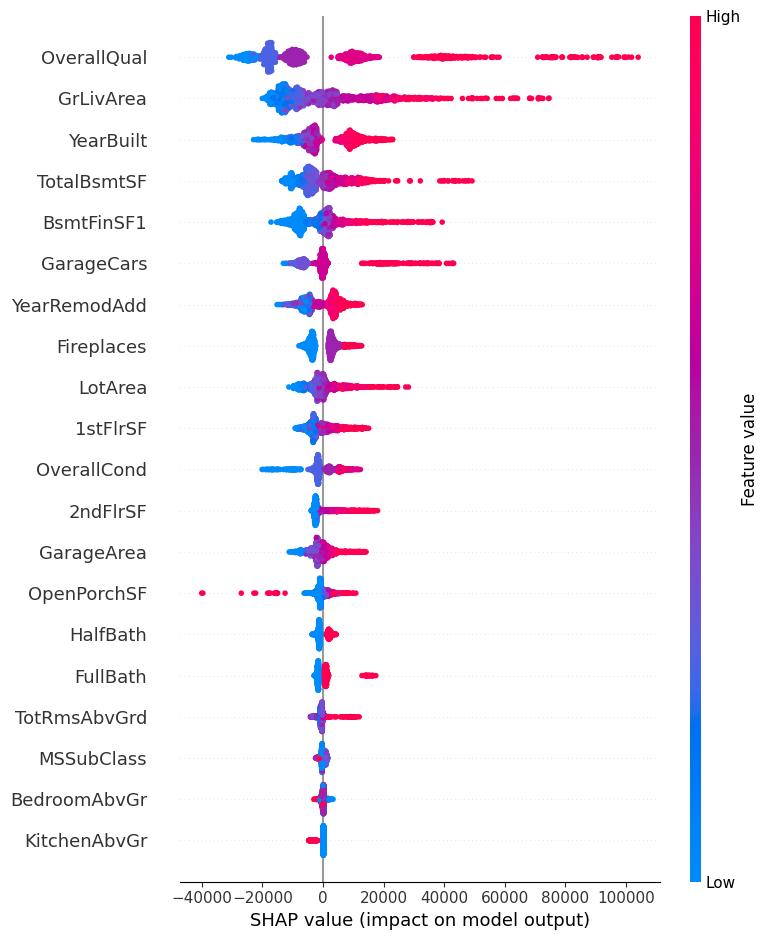

In [95]:
shap_values = shap.TreeExplainer(best_model).shap_values(X)
shap.summary_plot(shap_values, X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


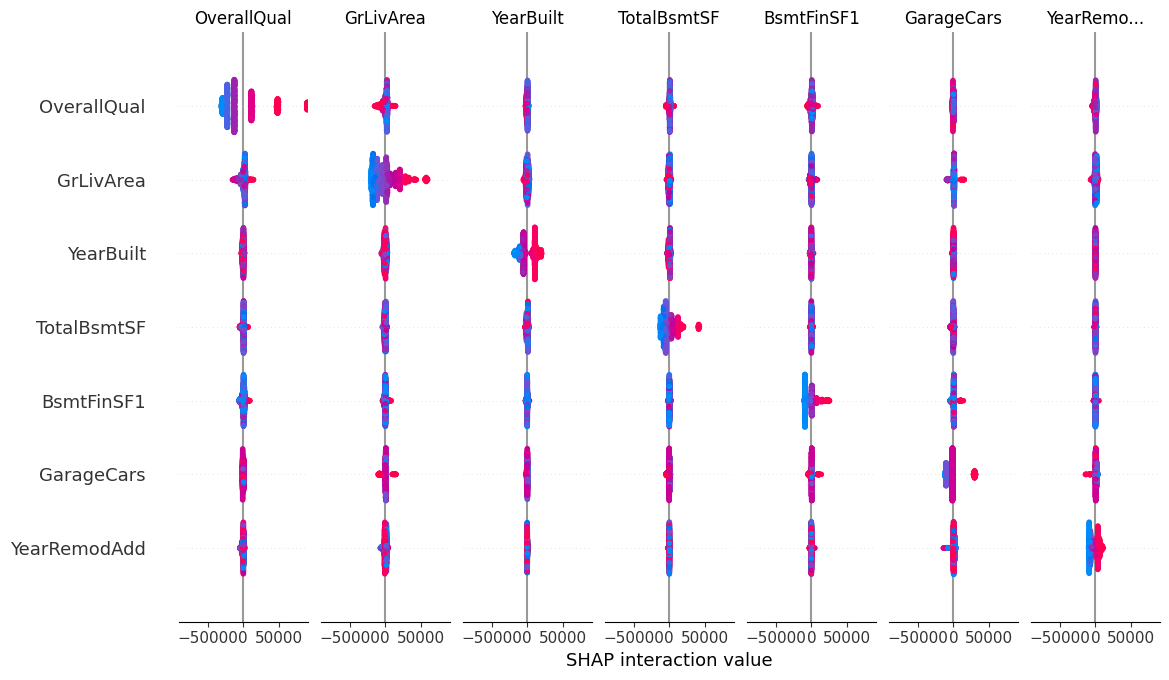

In [97]:
shap_interaction_values = shap.TreeExplainer(best_model).shap_interaction_values(X.iloc[:,:])
shap.summary_plot(shap_interaction_values, X.iloc[:,:])

In [116]:
predictLGBM = best_model.predict(df_test)
submissionLGBM = pd.DataFrame({'SalePrice':predictLGBM})
# display(submissionLGBM.head())
print(submissionLGBM.iloc[0].values)

,SalePrice
0,127368.782722
1,156700.928621
2,180422.435175
3,183877.895502
4,186021.015175


[127368.78272224]
